In [1]:
from common.Parameters import Para
from common.EstimatedCSI import EstimatedCSI
from common.BuildDataset import GenerateDataset, SignalDataset
from common.dnn import BackscatterDNN, accuracy

import numpy as np
import torch as T
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
%%time
para = Para(vary=1, n_dataset=100, n_test=100) #SNR = vary, default: n_dataset=100
D, dataset = GenerateDataset(para)

train_ds = SignalDataset(dataset)
bat_size = 1000
train_ldr = T.utils.data.DataLoader(train_ds, batch_size=bat_size, shuffle=True)

validate_dataset = SignalDataset(GenerateDataset(Para(vary=1,n_dataset=10))[1])

Vary alpha_dt:1
Vary alpha_dt:1
Wall time: 54.8 s


In [3]:
D.shape, dataset.shape

((10000, 201), (10000, 601))

learning rate:0.001
==== Training ====

epoch =    0   loss = 3.9580
acc_train = 0.9540

epoch =   10   loss = 0.2652
acc_train = 0.9460

epoch =   20   loss = 0.2554
acc_train = 0.9460

epoch =   30   loss = 0.2337
acc_train = 0.9430

epoch =   40   loss = 0.1848
acc_train = 0.9460

epoch =   50   loss = 0.1591
acc_train = 0.9470

epoch =   60   loss = 0.3599
acc_train = 0.9430

epoch =   70   loss = 0.2777
acc_train = 0.9470

epoch =   80   loss = 0.1521
acc_train = 0.9380

epoch =   90   loss = 0.1391
acc_train = 0.9400
Done 
Wall time: 5min 5s


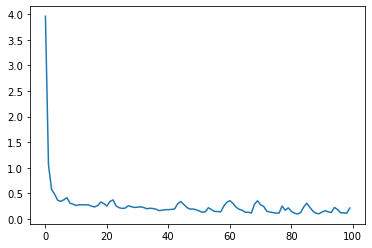

In [4]:
%%time
row, col = dataset.shape
input_size=(col-1)
numClasses = 2
backscatter_net = BackscatterDNN(input_size=input_size,numClasses=numClasses)

running_loss=[]
running_acc=[]

print('==== Training ====')
max_epochs = 100
ep_log_interval = 10

for epoch in range(0, max_epochs):
    epoch_loss = 0.0            # for one full epoch
    epoch_loss_custom = 0.0
#     num_lines_read = 0
    acc_train = 0
    
    for (batch_idx, batch) in enumerate(train_ldr):
        X = batch['predictors']  # [10,4]  inputs
#         print(X.shape)
        Y = batch['target']      # [10,1]  targets
#         print(f'Y \n{Y}')
        oupt = backscatter_net(X)           # [10,1]  computeds 
#         print('out:\n',oupt)
        loss_val = backscatter_net.loss(oupt, Y)   # a tensor
        epoch_loss += loss_val.item()  # accumulate

        backscatter_net.optimizer.zero_grad() # reset all gradients
        loss_val.backward()   # compute all gradients
        backscatter_net.optimizer.step()      # update all weights
        
    ##########
    running_loss.append(epoch_loss)
    backscatter_net.eval()
    acc_train = accuracy(backscatter_net, validate_dataset)
    backscatter_net.train()
    running_acc.append(acc_train)
    ##########
        
    if epoch % ep_log_interval == 0:
        print("\nepoch = %4d   loss = %0.4f" % \
                (epoch, epoch_loss))
        print("acc_train = %0.4f" % acc_train)
        # print("")
plt.plot(running_loss)
        
print("Done ")

(0.0, 1.0)

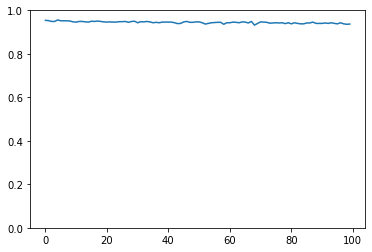

In [ ]:
plt.plot(running_acc)
plt.ylim([0,1])

In [16]:
backscatter_net.eval()
inpts = train_ds[0]['predictors']
target = train_ds[0]['target']    # float32  [0.0] or [1.0]
with T.no_grad():
    oupt = backscatter_net(inpts)
oupt>=0.5

tensor([False])

In [6]:
backscatter_net.eval()
acc_train = accuracy(backscatter_net, train_ds)
print("\nAccuracy on train data = %0.2f%%" %(acc_train * 100))


Accuracy on train data = 98.45%


In [39]:
backscatter_net.train()

BackscatterDNN(
  (model): Sequential(
    (0): Linear(in_features=600, out_features=600, bias=True)
    (1): Tanh()
    (2): Linear(in_features=600, out_features=1000, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1000, out_features=600, bias=True)
    (5): Tanh()
    (6): Linear(in_features=600, out_features=1, bias=True)
    (7): Sigmoid()
  )
  (loss): BCELoss()
)

In [7]:
%%time
results=[]
for i in range(10):

    D2 = GenerateDataset(para)
    numRow2, numCol2 = D2.shape
    dataset2 = np.asmatrix(D2)
    dataset2 = np.concatenate((np.real(dataset2[:,:numCol2-1]),np.imag(dataset2[:,:numCol2-1]),
                              np.absolute(dataset2[:,:numCol-1]),np.real(dataset2[:,-1])),axis=1)
    test_ds = SignalDataset(dataset2)
    test_acc = accuracy(backscatter_net, test_ds)
    results.append(test_acc)
    print(f'\nIteration:{i}')
    print("Accuracy on test data = %0.2f%%" %(test_acc * 100))
    


Iteration:0
Accuracy on test data = 93.53%

Iteration:1
Accuracy on test data = 93.89%

Iteration:2
Accuracy on test data = 93.37%

Iteration:3
Accuracy on test data = 95.17%

Iteration:4
Accuracy on test data = 93.96%

Iteration:5
Accuracy on test data = 96.06%

Iteration:6
Accuracy on test data = 92.61%

Iteration:7
Accuracy on test data = 90.69%

Iteration:8
Accuracy on test data = 94.49%

Iteration:9
Accuracy on test data = 94.69%
Wall time: 9min 37s


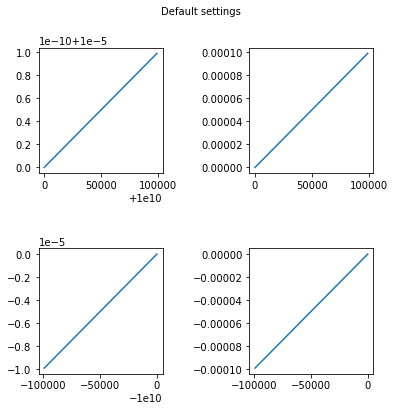

In [3]:
x = np.arange(0, 1, .01)
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(6, 6))
fig.text(0.5, 0.975, 'Default settings',
         horizontalalignment='center',
         verticalalignment='top')

ax1.plot(x * 1e5 + 1e10, x * 1e-10 + 1e-5)

ax2.plot(x * 1e5, x * 1e-4)

ax3.plot(-x * 1e5 - 1e10, -x * 1e-5 - 1e-10)

ax4.plot(-x * 1e5, -x * 1e-4)

fig.subplots_adjust(wspace=0.7, hspace=0.6)